# Oct 15-16,21-25, Nov 7, 2023: overlapping communities: runwise: hierarchical bootstrapping of memberships

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product, permutations
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
from sympy.utilities.iterables import multiset_permutations
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from munkres import Munkres

# networks
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
import ants
from nipype.interfaces import afni

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240117-15:31:11,967 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.parcel_name = 'whole'
args.rois_folder = 'yale_172' # 'hadi_1445'

hadi_1445_img = (
    f'{os.environ["HOME"]}/mouse_dataset/allen_atlas_ccfv3/hadi/parcellation'
    f'/warped_on_n162/{args.parcel_name}_parcels_warped_cm.nii.gz'
)
yale_172_img = (
    f'{os.environ["HOME"]}/mouse_dataset' 
    f'/n162_parcellations/172_parcels_RAS_cm.nii.gz'
)
yale_56_img = (
    f'{os.environ["HOME"]}/mouse_dataset' 
    f'/n162_parcellations/56_parcels_RAS_cm.nii.gz'
)

hadi_1445_rois = (
    f'{os.environ["HOME"]}/mouse_dataset/allen_atlas_ccfv3/hadi/parcellation'
    f'/warped_on_n162/{args.parcel_name}_roi_labels.txt'
)
yale_172_rois = (
    f'{os.environ["HOME"]}/mouse_dataset' 
    f'/n162_parcellations/172_roi_labels.txt'
)
yale_56_rois = (
    f'{os.environ["HOME"]}/mouse_dataset' 
    f'/n162_parcellations/56_roi_labels.txt'
)

parcels_img = ants.image_read(yale_172_img)
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(yale_172_rois)
roi_labels.shape

(172,)

In [4]:
args.num_subs = 10
args.num_sess = 3
args.num_rois = roi_labels.shape[0]
args.num_comms = 7 # <<<<<<========
args.thresh = 0.15 #1 / args.num_comms # removing comm. memberships below uniform distribution
args.num_resamples = 1000


BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi'
COMM_path = f'{BASE_path}/{args.rois_folder}/svinet_folders/{args.parcel_name}/k{args.num_comms}'
NPY_path = f'{BASE_path}/{args.rois_folder}/npy_files'
ESTM_path = f'{BASE_path}/{args.rois_folder}/estimates'
cmd = (
    f'mkdir -p {ESTM_path}'
)
os.system(cmd)

0

In [5]:
args.num_rois

172

---

In [6]:
# folders ordered hierarchically
def get_main_sample(args):
    main_sample = [
        [
            []
            for ses in range(args.num_sess)
        ]
        for sub in range(args.num_subs)
    ]
    for folder in os.listdir(COMM_path):
        fs = folder.split('_')
        if int(fs[2].split('-')[-1]) % 2 == 0: continue # skip even runs
        sub = int(fs[0].split('-')[-1][-2:])
        ses = int(fs[1].split('-')[-1])
        # run = int(fs[2].split('-')[-1])
        main_sample[sub-1][ses-1].append(folder)

    for sub in np.arange(1,args.num_subs+1):
        for ses in np.arange(1, args.num_sess+1):
            main_sample[sub-1][ses-1] = list(np.sort(main_sample[sub-1][ses-1]))
    return main_sample

In [7]:
def get_main_groups(args, main_sample):
    # collect community (a.k.a. group) memberships
    groups_sample = [
        [
            []
            for ses in range(args.num_sess)
        ]
        for sub in range(args.num_subs)
    ]
    for sub in range(args.num_subs):
        for ses in range(args.num_sess):
            for run in main_sample[sub][ses]:
                groups_file = [file for file in os.listdir(f'{COMM_path}/{run}') if 'groups.txt' in file][0]
                groups_file = f'{COMM_path}/{run}/{groups_file}'
                gs_ = np.loadtxt(groups_file)
                groups = np.zeros((args.num_rois, args.num_comms))
                groups[gs_[:, 1].astype(int), :] = gs_[:, 2:]
                groups_sample[sub][ses].append(groups)   
    return groups_sample

In [8]:
def reference_comms(args, groups_sample, ):
    # k-means cluster centroids
    X = []
    for sub in groups_sample:
        for ses in sub:
            for run in ses:
                X.append(run)
    X = np.concatenate(X, axis=-1)
    kmeans = KMeans(
        n_clusters=args.num_comms, 
        init='k-means++', n_init=50, 
        random_state=args.SEED
    ).fit(X=X.T)
    comm_cntrs = kmeans.cluster_centers_.T # num_rois x num_comms
    return comm_cntrs

def align_two_partitions(args, source_comms, target_comms):
    # align source onto target
    
    # distatnce matrix
    D = 1 - cosine_similarity(target_comms.T, source_comms.T)
    # Hungarian permutation method
    best_pi = list(zip(*Munkres().compute(D)))[1]
    source_comms = source_comms[:, best_pi]
    return source_comms, best_pi

def align_partitions(args, groups_sample):
    comm_cntrs = reference_comms(args, groups_sample)
    
    for idx_sub, sub in enumerate(groups_sample):
        for idx_ses, ses in enumerate(sub):
            for idx_run, run in enumerate(ses):
                (
                    run, 
                    best_pi,
                ) = align_two_partitions(
                    args, 
                    source_comms=run, 
                    target_comms=comm_cntrs
                )
                groups_sample[idx_sub][idx_ses][idx_run] = run
                # print(idx_sub, idx_ses, idx_run, best_pi)
    return groups_sample

In [9]:
def resample(args, groups_main_sample):
    subs = groups_main_sample
    groups_resample = [[] for _ in range(len(subs))]
    for idx_sub, sub in enumerate(
        np.random.choice(
            np.arange(1, len(subs)+1), 
            size=len(subs), replace=True
        )
    ):
        sess = groups_main_sample[sub-1]
        groups_resample[idx_sub] = [[] for _ in range(len(sess))]
        for idx_ses, ses in enumerate(
            np.random.choice(
                np.arange(1, len(sess)+1), 
                size=len(sess)
            )
        ):
            runs = groups_main_sample[sub-1][ses-1]
            groups_resample[idx_sub][idx_ses] = [None for _ in range(len(runs))]
            for idx_run, run in enumerate(
                np.random.choice(
                    np.arange(1, len(runs)+1),
                    size=len(runs)
                )
            ):
                groups_resample[idx_sub][idx_ses][idx_run] = runs[run-1]
    return groups_resample

In [10]:
def sample_mean(args, groups_sample):
    groups = []
    for sub in groups_sample:
        for ses in sub:
            for run in ses:
                groups.append(run)
    return np.mean(groups, axis=0)

In [11]:
def bootstrap(args, sample):
    statistics = []
    for idx in tqdm(np.arange(args.num_resamples)):
        re_sample = resample(args, sample)
        statistics.append(sample_mean(args, re_sample))
    
    mean_stats, ste_stats = np.median(statistics, axis=0), np.std(statistics, axis=0)
    if args.sample_type == 'comm_member':
        # remove values below thresh
        thresh = mean_stats > args.thresh
        mean_stats *= thresh
        ste_stats *= thresh
    return statistics, mean_stats, ste_stats

---

100%|██████████| 1000/1000 [00:00<00:00, 1044.06it/s]


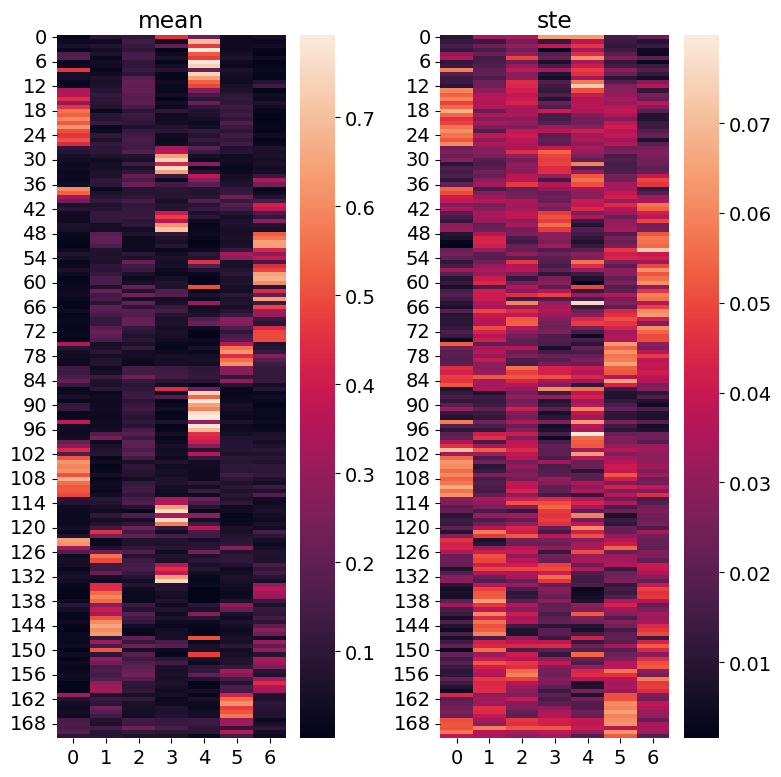

In [12]:
main_sample = get_main_sample(args)
groups_main_sample = get_main_groups(args, main_sample)
groups_main_sample= align_partitions(args, groups_main_sample)

args.sample_type = 'comm_member_'
groups, groups_mean, groups_ste = bootstrap(args, groups_main_sample)

with open(f'{NPY_path}/community_memberships_{args.parcel_name}_k{args.num_comms}.npy', 'wb') as f:
    pickle.dump([groups_mean, groups_ste], f)

fig, axs = plt.subplots(1, 2, figsize=(8, 8))
sns.heatmap(groups_mean, ax=axs[0], cbar=True, )# cmap=cmr.iceburn, center=0)
axs[0].set_title('mean')
sns.heatmap(groups_ste, ax=axs[1], cbar=True, )# cmap=cmr.iceburn, center=0)
axs[1].set_title('ste')
fig.tight_layout()

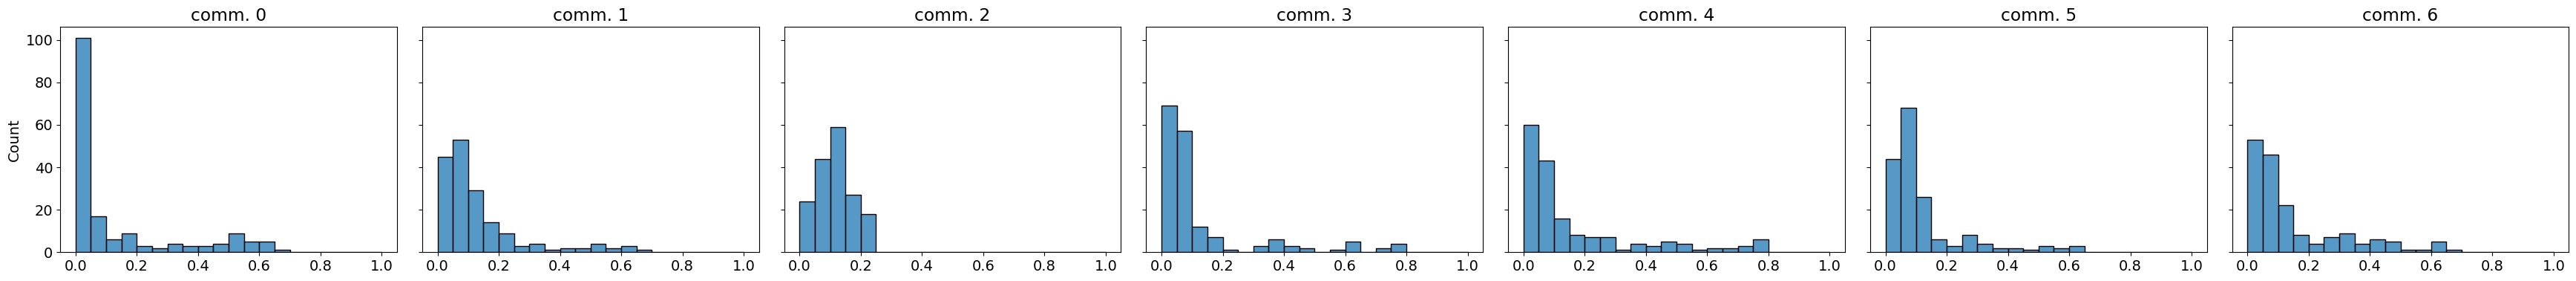

In [13]:
nrows, ncols = 1, args.num_comms
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows),sharey=True)
for k in np.arange(args.num_comms):
    ax = axs[k]
    vals = groups_mean[:,k]
    vals = vals[vals!=0]
    sns.histplot(vals,ax=ax, stat='count', binwidth=0.05, binrange=[0, 1])
    ax.set(title=f'comm. {k}')
fig.tight_layout()

<Axes: >

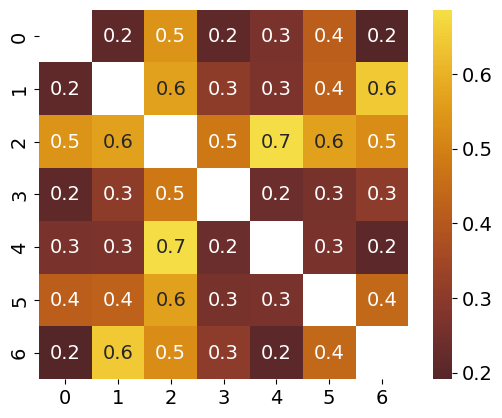

In [14]:
# similarity between communities
R = cosine_similarity(groups_mean.T)
R[np.diag_indices(R.shape[0])] = None
sns.heatmap(R, square=True, annot=True, fmt='.1f', center=0.0, cmap=cmr.iceburn)

In [15]:
for comm in range(args.num_comms):
    groups_img = np.zeros_like(parcels)
    for idx, roi in enumerate(roi_labels.astype(int)):
        groups_img += (parcels == roi) * groups_mean[idx, comm]

    parcels_img.new_image_like(
        groups_img
    ).to_filename(f'{ESTM_path}/hboot_mean_comm{comm}.nii.gz')

out_file = f'{ESTM_path}/hboot_mean_{args.parcel_name}_k{args.num_comms}.nii.gz'
try:
    os.remove(out_file)
except:
    pass

tcat = afni.TCat()
tcat.inputs.in_files = [
    f'{ESTM_path}/hboot_mean_comm{comm}.nii.gz'
    for comm in range(args.num_comms)
]
tcat.inputs.out_file = out_file
tcat.inputs.rlt = ''
tcat.cmdline
res = tcat.run()

for comm in range(args.num_comms):
    try:
        os.remove(f'{ESTM_path}/hboot_mean_comm{comm}.nii.gz')
    except:
        pass

240117-15:31:19,555 nipype.interface INFO:
	 stderr 2024-01-17T15:31:19.554854:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
240117-15:31:19,559 nipype.interface INFO:
	 stderr 2024-01-17T15:31:19.559379:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
240117-15:31:19,560 nipype.interface INFO:
	 stderr 2024-01-17T15:31:19.560353:*+ WARNING: Set TR of output dataset to 1.0 s
240117-15:31:19,632 nipype.interface INFO:
	 stderr 2024-01-17T15:31:19.632021:++ elapsed time = 0.1 s


---

In [16]:
def statistic_main_sample(args, groups_main_sample, statstic):
    stat_main_sample = deepcopy(groups_main_sample)
    for idx_sub, sub in enumerate(stat_main_sample):
        for idx_ses, ses in enumerate(sub):
            for idx_run, run in enumerate(ses):
                stat_main_sample[idx_sub][idx_ses][idx_run] = statstic(run)
    return stat_main_sample

 43%|████▎     | 430/1000 [00:00<00:00, 1430.15it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1429.56it/s]


Text(0.5, 0, 'entropy')

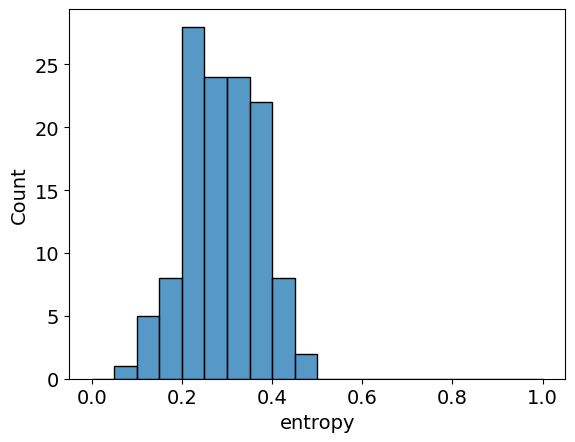

In [17]:
entropy_main_sample = statistic_main_sample(
    args, 
    groups_main_sample,
    statstic=lambda x: stats.entropy(x, base=2, axis=-1) / np.log2(args.num_comms)
)
args.sample_type = 'entropy'
entropy_resamples, mean_entropy, ste_entropy = bootstrap(args, entropy_main_sample)

mean_entropy[np.isnan(mean_entropy)] = 0

with open(f'{NPY_path}/memberships_entropy_{args.parcel_name}_k{args.num_comms}.npy', 'wb') as f:
    pickle.dump([mean_entropy, ste_entropy], f)

entropy_img = np.zeros_like(parcels)
for idx, roi in enumerate(roi_labels.astype(int)):
    entropy_img += (parcels == roi) * mean_entropy[idx]

parcels_img.new_image_like(
    entropy_img
).to_filename(f'{ESTM_path}/hboot_mean_entropy_{args.parcel_name}_k{args.num_comms}.nii.gz')

sns.histplot(mean_entropy[mean_entropy!=0], stat='count', binwidth=0.05, binrange=[0, 1])
# plt.vlines(x=np.log2(args.num_comms), ymin=0, ymax=1, color='red', linewidth=5)
plt.xlabel('entropy')

---

In [18]:
with open(f'{NPY_path}/func_nws_{args.parcel_name}.npy', 'rb') as f:
    fcs = pickle.load(f)
    
degree_main_sample = statistic_main_sample(
    args, 
    fcs, 
    statstic=lambda x: np.sum(x, axis=0)
)
degree_resamples, mean_degree, ste_degree = bootstrap(args, degree_main_sample)

degree_img = np.zeros_like(parcels)
for idx, roi in enumerate(roi_labels.astype(int)):
    degree_img += (parcels == roi) * mean_degree[idx]

parcels_img.new_image_like(
    degree_img
).to_filename(f'{ESTM_path}/hboot_mean_degree_{args.parcel_name}_k{args.num_comms}.nii.gz')


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1422.19it/s]


---

---